**Install Featureform**


In [1]:
!pip3 install featureform
import featureform as ff

**Download and register transaction file**

In [2]:
import requests
url = "https://featureform-demo-files.s3.amazonaws.com/transactions.csv"
r = requests.get(url)
open("transactions.csv" , 'wb').write(r.content)


77027840

In [3]:
from featureform import local

transactions = local.register_file(
    name="transactions",
    description="A dataset of fraudulent transactions",
    path="transactions.csv"
)
df = transactions.pandas()
df.head()

,TransactionID,CustomerID,CustomerDOB,CustLocation,CustAccountBalance,TransactionAmount,Timestamp,IsFraud
0,T1,C5841053,10/1/94,JAMSHEDPUR,17819.05,25.0,2022-04-09 11:33:09,False
1,T2,C2142763,4/4/57,JHAJJAR,2270.69,27999.0,2022-03-27 01:04:21,False
2,T3,C4417068,26/11/96,MUMBAI,17874.44,459.0,2022-04-07 00:48:14,False
3,T4,C5342380,14/9/73,MUMBAI,866503.21,2060.0,2022-04-14 07:56:59,True
4,T5,C9031234,24/3/88,NAVI MUMBAI,6714.43,1762.5,2022-04-13 07:39:19,False


**Define and test a few transformations**

In [4]:
@local.df_transformation(inputs=[transactions])
def average_user_transaction(transactions):
    return transactions.groupby("CustomerID")["TransactionAmount"].mean()

avg = average_user_transaction(df)
avg.head()

CustomerID
C1010011    2553.0
C1010012    1499.0
C1010014     727.5
C1010018      30.0
C1010024    5000.0
Name: TransactionAmount, dtype: float64

<AxesSubplot:ylabel='Frequency'>

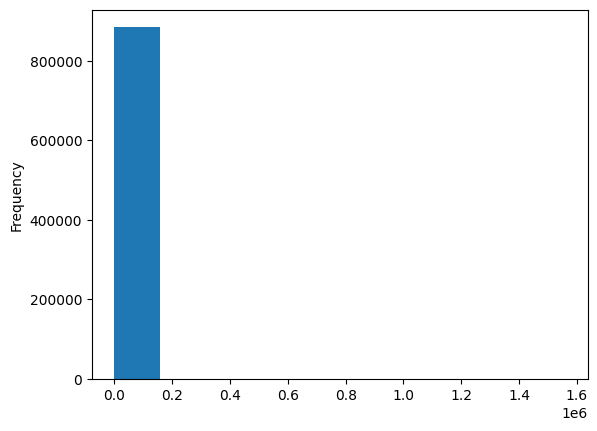

In [5]:
avg.plot(kind="hist")

<AxesSubplot:ylabel='Frequency'>

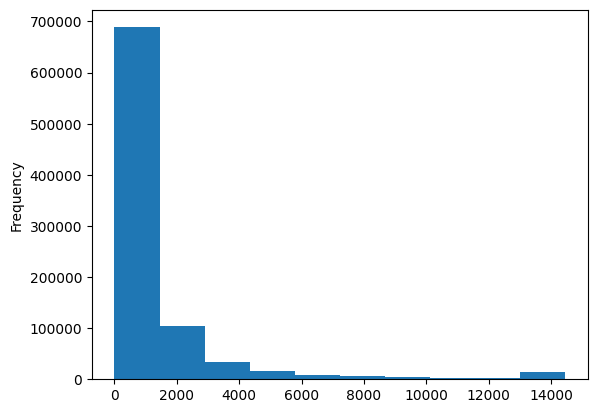

In [6]:
@local.df_transformation(variant="clipped",
                         inputs=[average_user_transaction])
def average_user_transaction(transactions):
    max = transactions.mean() + 2 * transactions.std()
    return transactions.clip(lower=0, upper=max)

average_user_transaction(avg).plot(kind="hist")

**Registering resources (Entity, feature, label)**

In [7]:
user = ff.register_entity("user")
# Register a column from our transformation as a feature
average_user_transaction.register_resources(
    entity=user,
    entity_column="CustomerID",
    inference_store=local,
    features=[
        {"name": "avg_transactions", "column": "TransactionAmount", "type": "float32"},
    ],
)

# Register a label from our base Transactions table
transactions.register_resources(
    entity=user,
    entity_column="CustomerID",
    labels=[
        {"name": "fraudulent", "column": "IsFraud", "type": "bool"},
    ],
)

**Registering training set**

In [8]:
ff.register_training_set(
    "fraud_training",
    label="fraudulent",
    features=["avg_transactions"],
)


**Apply our definitions**

In [9]:
client = ff.ResourceClient(local=True)
client.apply()

Creating provider local-mode
Creating user default_user
Creating source transactions
Creating source average_user_transaction
Creating source average_user_transaction
Creating entity user
Creating feature avg_transactions
Creating label fraudulent
Creating training-set fraud_training


**Train a Model**

In [13]:
serving = ff.ServingClient(local=True)
dataset = serving.training_set("fraud_training", "default")
training_dataset = dataset.repeat(1).shuffle(1000).batch(12)

In [14]:
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(loss='log_loss')
for batch in training_dataset:
  classifier.partial_fit(batch.features(), batch.label(), [True, False])

# Get one batch of training data as sample test data
# Make a test prediction
classifier.predict(batch.features())


array([False, False])